




<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [ ]:


import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout



In [ ]:
import tensorflow as tf

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.11.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.11.0


## Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading Wildfire Prediction Dataset




In [ ]:

def process_img(filepath):
    filenames = list(Path(filepath).glob(r'**/*{}'.format('jpg')))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filenames))
    
    filepaths = pd.Series(filenames, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df.sample(frac=.1)

In [ ]:
train_path = "/content/gdrive/MyDrive/MSDS 458 Colab/Assignment 4/train"
valid_path = "/content/gdrive/MyDrive/MSDS 458 Colab/Assignment 4/valid"
test_path = "/content/gdrive/MyDrive/MSDS 458 Colab/Assignment 4/test"

train_df = process_img(train_path)
val_df = process_img(valid_path)
test_df = process_img(test_path)

In [ ]:
train_df.head()

,Filepath,Label
14532,/content/gdrive/MyDrive/MSDS 458 Colab/Assignm...,wildfire
25576,/content/gdrive/MyDrive/MSDS 458 Colab/Assignm...,wildfire
3986,/content/gdrive/MyDrive/MSDS 458 Colab/Assignm...,nowildfire
12807,/content/gdrive/MyDrive/MSDS 458 Colab/Assignm...,nowildfire
23650,/content/gdrive/MyDrive/MSDS 458 Colab/Assignm...,wildfire


**Image Data Generators**

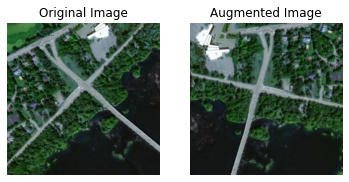

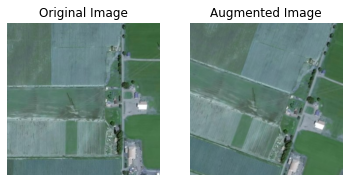

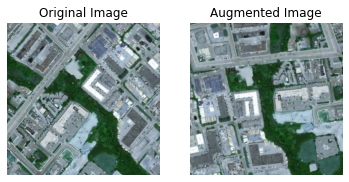

In [ ]:
def augment_image(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image

    
def show_original_augment_image(df):
    random_data = df.sample(n=3)
    for i in range(len(random_data)):
        image = cv2.imread(random_data.iloc[i].Filepath)
        augmented_image = augment_image(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

show_original_augment_image(train_df)

In [ ]:
BATCH_SIZE = 256
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augment_image)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')
test_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (224,224),
                                                    class_mode = 'categorical')

Found 3025 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.
Found 630 validated image filenames belonging to 2 classes.


## EDA Training and Test Datasets



## Plot Subset of Examples

**Inspect Images from Datset**

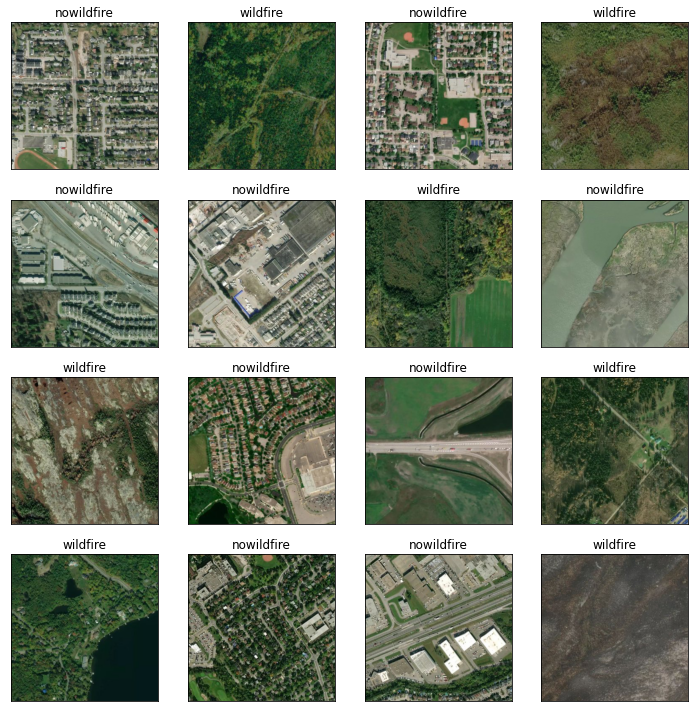

In [ ]:
def show_image_sample(df):
    random_data = df.sample(n=16)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(random_data.iloc[i].Filepath))
        ax.set_title(random_data.iloc[i].Label)
    plt.tight_layout()
    plt.show()
    
show_image_sample(train_df)

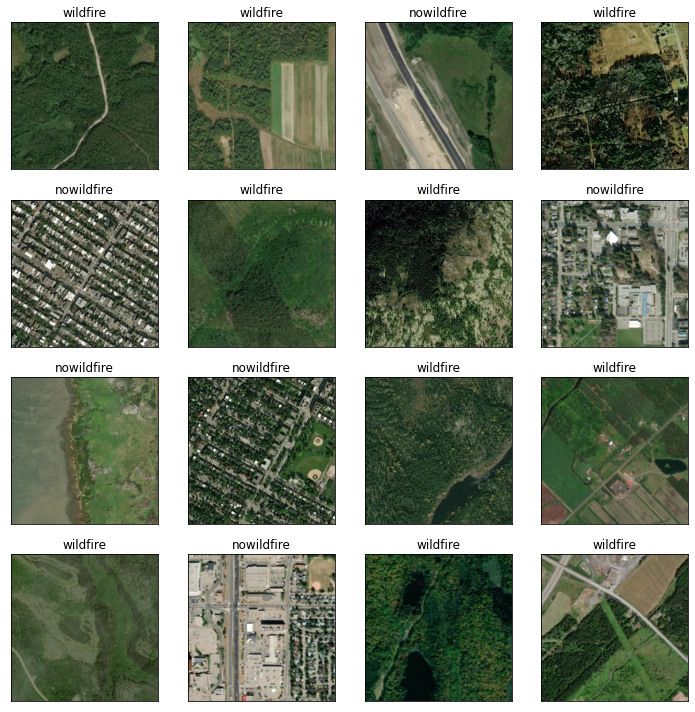

In [ ]:
show_image_sample(test_df)

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Build CNN Model

Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [ ]:
#inputs = Input(shape=(350, 350, 3))
#outputs = Dense(2, activation='softmax')(x)
from keras.applications.vgg16 import VGG16

VGG = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in VGG.layers:
  layer.trainable=False

model = keras.models.Sequential()
model.add(VGG)
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 128)         65664     
                                                                 
 dense_1 (Dense)             (None, 7, 7, 128)         16512     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12546     
                                                                 
Total params: 14,809,410
Trainable params: 94,722
Non-trainable params: 14,714,688
________________________________________

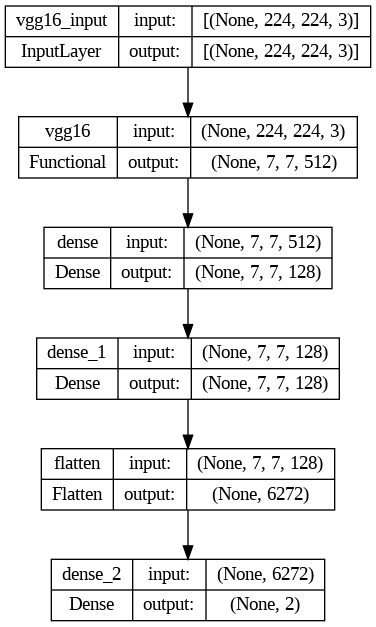

In [ ]:
keras.utils.plot_model(model, "Wildfire.png", show_shapes=True) 

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

## Training the model

In [ ]:
# don't stop everything if an image didn't load correctly
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
# early stopping to stop the training if our validation loss didn't decrease for (10) consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.Adam(learning_rate= 0.00001)
# setting our loss function and which metric to evaluate
model.compile(loss= 'categorical_crossentropy', optimizer= optimizer,
                    metrics=['accuracy'])

# TRAIN
history = model.fit(train_generator,
                    epochs = 200,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.4853 
Epoch 1: val_loss improved from inf to 0.74758, saving model to model.hdf5
12/12 [==============================] - 607s 50s/step - loss: 0.7521 - accuracy: 0.4853 - val_loss: 0.7476 - val_accuracy: 0.4397
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.4684
Epoch 2: val_loss improved from 0.74758 to 0.71041, saving model to model.hdf5
12/12 [==============================] - 134s 11s/step - loss: 0.7058 - accuracy: 0.4684 - val_loss: 0.7104 - val_accuracy: 0.4254
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5593
Epoch 3: val_loss improved from 0.71041 to 0.68946, saving model to model.hdf5
12/12 [==============================] - 134s 11s/step - loss: 0.6800 - accuracy: 0.5593 - val_loss: 0.6895 - val_accuracy: 0.5524
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

**Test Accuracy and Confusion Matrix**

In [ ]:
pred = np.argmax(model.predict(test_generator), axis=1)

3/3 [==============================] - 72s 31s/step


Accuracy score: 92.6984126984127


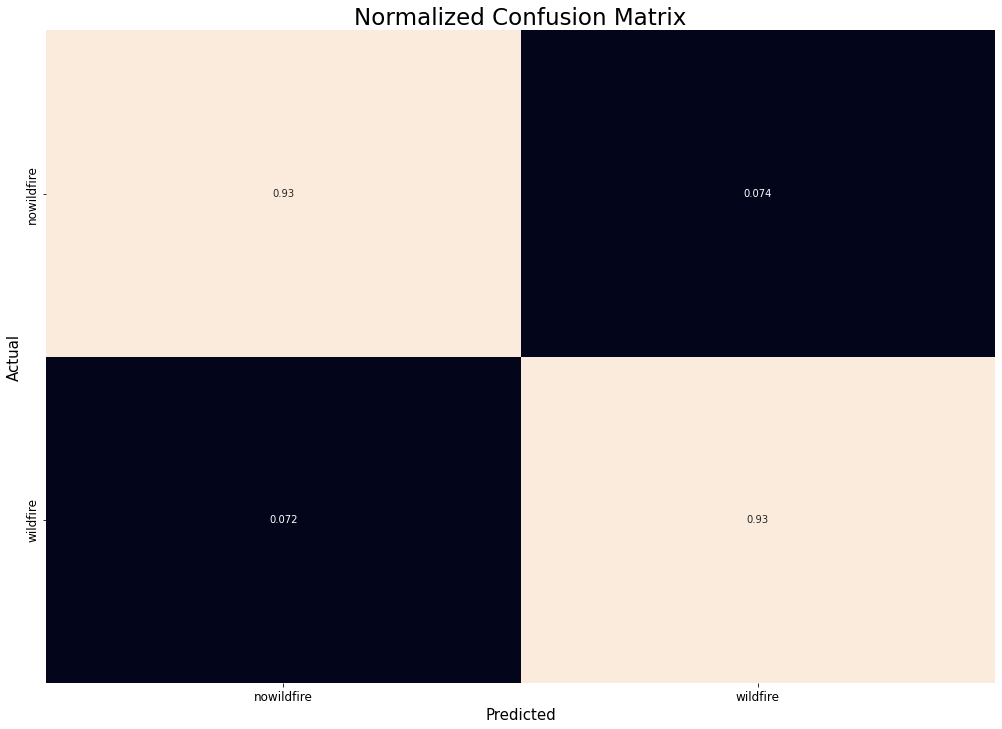

In [ ]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_label = [labels[k] for k in pred]
y_test = list(test_df.Label)

# Print accuracy score
score = accuracy_score(y_test,pred_label)
print(f'Accuracy score: {score * 100}')

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, pred_label, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Actual", fontsize=15)
plt.show()

## Predictions

## Plot Training Metrics (Loss and Accuracy)

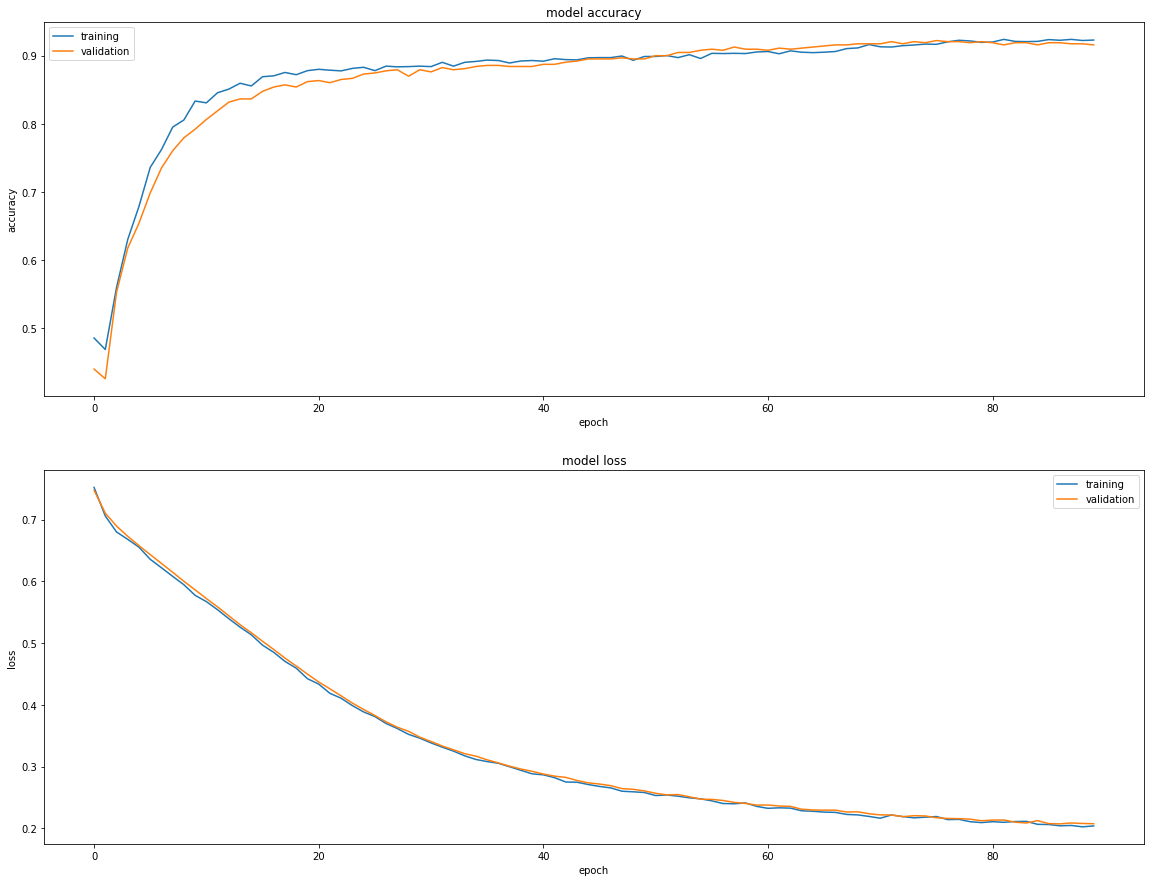

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)